In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import keras 
import os
import random
from datetime import datetime

from keras.layers import RandomFlip, RandomContrast, RandomBrightness, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Resizing
from keras.models import Sequential
from keras.layers import Input,  Conv2D, MaxPooling2D, Dense, Flatten, Dropout, SpatialDropout2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, Activation
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.image import random_flip_left_right, random_contrast, random_flip_up_down, random_brightness # type: ignore
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2 # type: ignore
from keras_tuner import Hyperband

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras import mixed_precision # type: ignore

In [3]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Loading dataset

In [4]:
DIR = '../data/playing_cards_dataset/'
TRAIN_DIR = DIR + 'train/'
TEST_DIR = DIR + 'test/'
VAL_DIR = DIR + 'valid/'
LOG_DIR = '../logs/'

EPOCHS = 100
BATCH_SIZE = 64

In [5]:
# Reading images from folders
train_dataset = keras.utils.image_dataset_from_directory(TRAIN_DIR, image_size=(224, 224), batch_size=BATCH_SIZE)
test_dataset = keras.utils.image_dataset_from_directory(TEST_DIR, image_size=(224, 224), shuffle='false', batch_size=BATCH_SIZE)
val_dataset = keras.utils.image_dataset_from_directory(VAL_DIR, image_size=(224, 224), shuffle='flase', batch_size=BATCH_SIZE)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [6]:
# Gathering sample images
test_images = []
test_labels = []

for images, labels in test_dataset.take(1):
    for i in range(len(images)):
        test_images.append(images[i])
        test_labels.append(labels[i])
    break

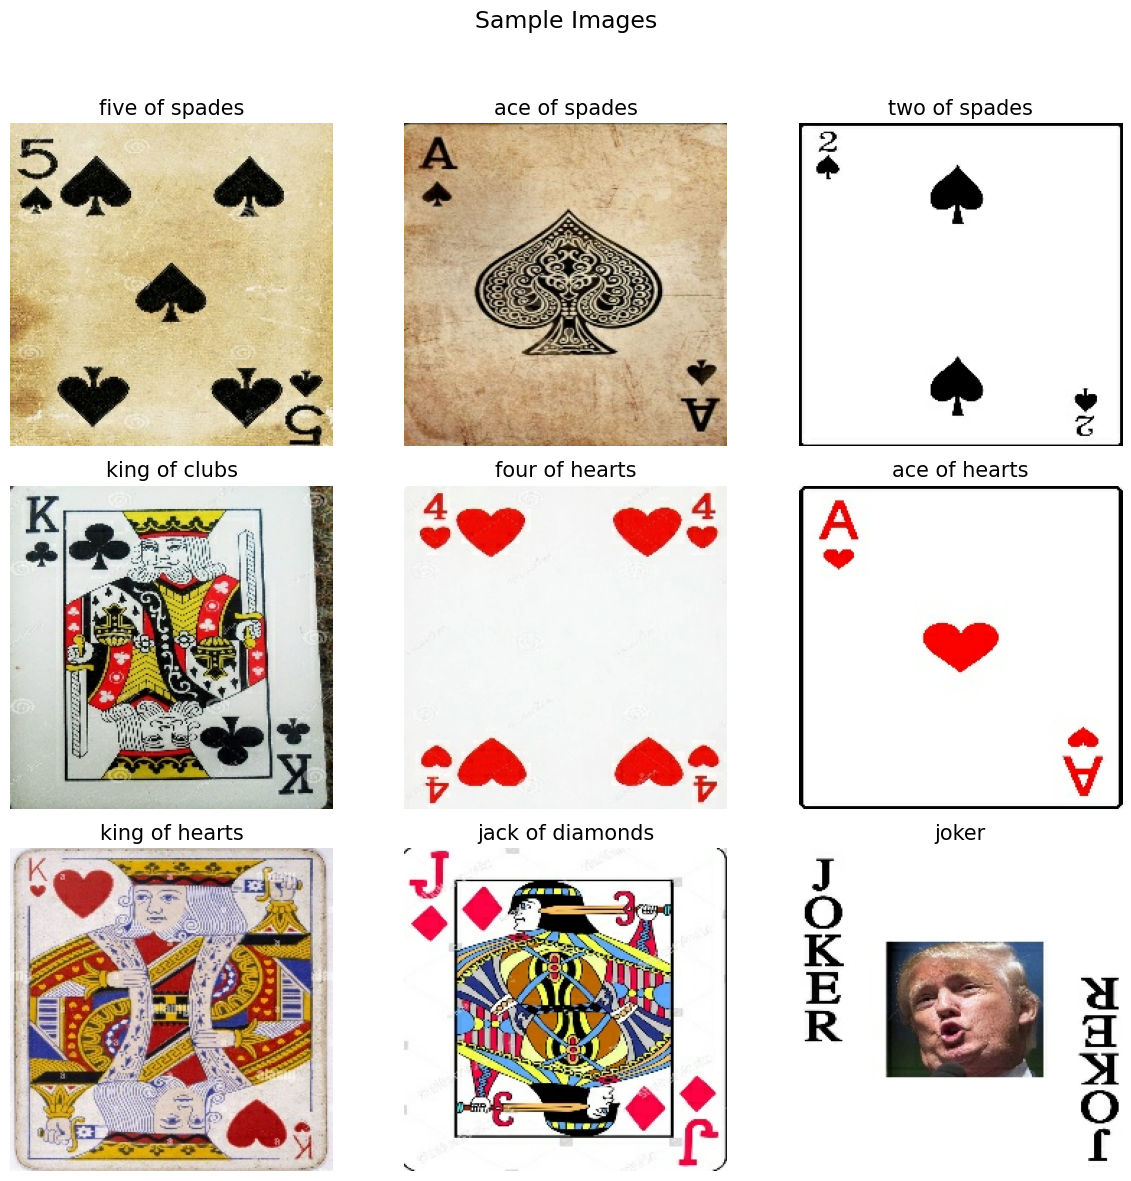

In [7]:
# Displaying 9 sample cards
plt.figure(figsize=(12, 12))
plt.suptitle('Sample Images', fontsize=17)

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i].numpy().astype('uint8'))
    plt.title(train_dataset.class_names[test_labels[i].numpy()], fontsize=15)
    plt.axis('off')
        
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Data Exploration

In [8]:
CLASSES = train_dataset.class_names
NUM_CLASSES = len(CLASSES)
IMG_SHAPE = test_images[0].shape

print(f'Amount of classes: {NUM_CLASSES}')
print(f'Image shape: {IMG_SHAPE}')
print(f'Pixel range: {np.min(test_images)} - {np.max(test_images)}')

Amount of classes: 53
Image shape: (224, 224, 3)
Pixel range: 0.0 - 255.0


Average cards per class: 143.8490566037736


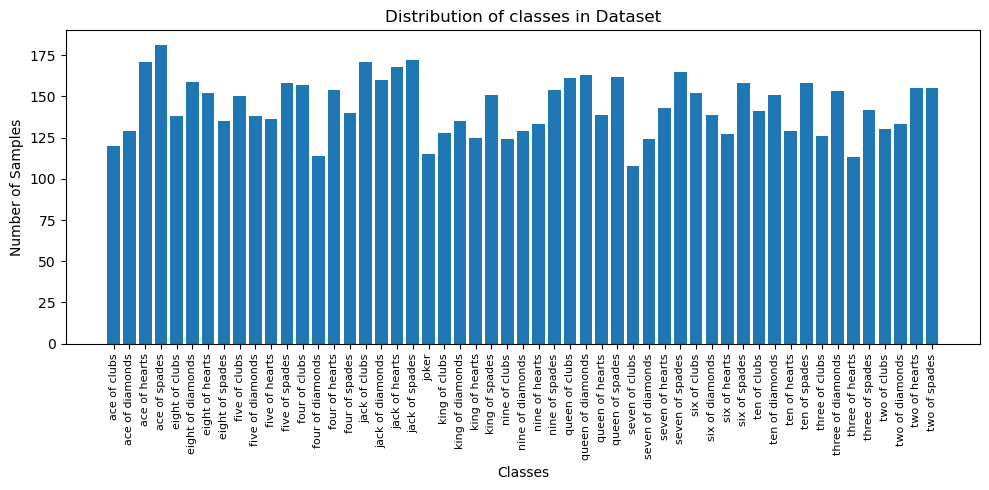

In [9]:
class_counts = {}

for c in CLASSES: 
    class_counts[c] = len(os.listdir(TRAIN_DIR + c))
    
class_mean = np.mean(list(class_counts.values()))
print(f'Average cards per class: {class_mean}')

plt.figure(figsize=(10, 5))  
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90, fontsize=8) 
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Distribution of classes in Dataset")
plt.tight_layout()
plt.show()

# Data Preprocessing

In [11]:
img_augmentation_layers = [
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomRotation(0.03, fill_mode='constant'),
    RandomZoom(height_factor=(-0.1, 0.0), width_factor=(-0.1, 0.0)), 
    # RandomErasing(factor=0.5), # Not available in current keras version
    Resizing(224, 224)
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

def preprocess(image, label): # Scaling pixels to range 0-1
    image = tf.cast(image, tf.float32) / 255
    return image, label

def preprocess_and_augment(image, label):
    image = img_augmentation(image)
    image, label = preprocess(image, label)
    return image, label

In [12]:
train_dataset = train_dataset.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

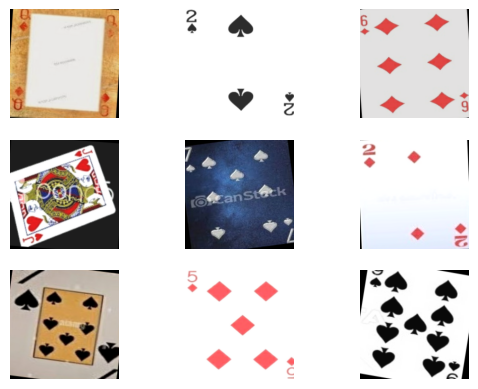

In [13]:
# Inspecting images after preprocessing
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        # plt.title(CLASSES[tf.argmax(labels[i], axis=1)])
        plt.axis("off")
    break


In [14]:
def evaluate_model(model, dataset=test_dataset, num_classes= NUM_CLASSES, classes= CLASSES):
    # Core metrics
    loss, accuracy = model.evaluate(dataset, verbose=0)
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')

    # Gather batch predictions
    y_pred, y_true, y_pred_probs = [], [], []
    for images, labels in dataset:
        batch_pred = model.predict(images, verbose=0)
        y_pred_probs.extend(batch_pred)
        y_pred.extend(tf.argmax(batch_pred, axis=1).numpy())  
        y_true.extend(labels.numpy())  
        
    precision = precision_score(y_true, y_pred, average='macro')
    print(f'Precision: {precision}')
    recall = recall_score(y_true, y_pred, average='macro')
    print(f'Recall: {recall}')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'F1: {f1}')
    
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    auc_macro = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')
    print(f"ROC AUC: {auc_macro}")

    # Classification report
    class_report = classification_report(y_true, y_pred, target_names=classes)
    print("\nClassification Report:")
    print(class_report)
    
    conf_maxtrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    plot_confustion_matrix(conf_maxtrix)
        
def plot_confustion_matrix(cm, classes=CLASSES):
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, linewidths=.5, cbar=False)
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_training_history(training, model_name='Model'):
    acc = training.history['accuracy']
    val_acc = training.history['val_accuracy']
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)

    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        verbose=1,
        patience=5,
        restore_best_weights=True
    ), 
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5, 
        patience=2,
        verbose=1,
        min_lr=1e-8 
    )
]

# Model 1: Logistic Regression

In [16]:
log_reg = Sequential([
    Flatten(input_shape=IMG_SHAPE),
    Dense(NUM_CLASSES, activation='softmax')
])

log_reg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
log_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 53)                7978037   
                                                                 
Total params: 7,978,037
Trainable params: 7,978,037
Non-trainable params: 0
_________________________________________________________________


In [17]:
# callbacks = callbacks + [TensorBoard(LOG_DIR + f'fit/logistic_regression/{datetime.now().strftime("%Y%m%d-%H%M%S")}')]

training = log_reg.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = callbacks,
    verbose = 1,
)

Epoch 1/100
120/120 [==============================] - 14s 9ms/step - loss: 284.8744 - accuracy: 0.0567 - val_loss: 49.2851 - val_accuracy: 0.1208 - lr: 0.0010
Epoch 2/100
120/120 [==============================] - 12s 9ms/step - loss: 50.7074 - accuracy: 0.1393 - val_loss: 62.0000 - val_accuracy: 0.1585 - lr: 0.0010
Epoch 3/100
120/120 [==============================] - 13s 8ms/step - loss: 61.2834 - accuracy: 0.1497 - val_loss: 90.2159 - val_accuracy: 0.1774 - lr: 0.0010
Epoch 4/100
120/120 [==============================] - 13s 9ms/step - loss: 56.7732 - accuracy: 0.1696 - val_loss: 43.5049 - val_accuracy: 0.2377 - lr: 0.0010
Epoch 5/100
120/120 [==============================] - 13s 9ms/step - loss: 42.9551 - accuracy: 0.2012 - val_loss: 51.0996 - val_accuracy: 0.2302 - lr: 0.0010
Epoch 6/100
120/120 [==============================] - 13s 10ms/step - loss: 46.6312 - accuracy: 0.1929 - val_loss: 36.6666 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 7/100
120/120 [=======================

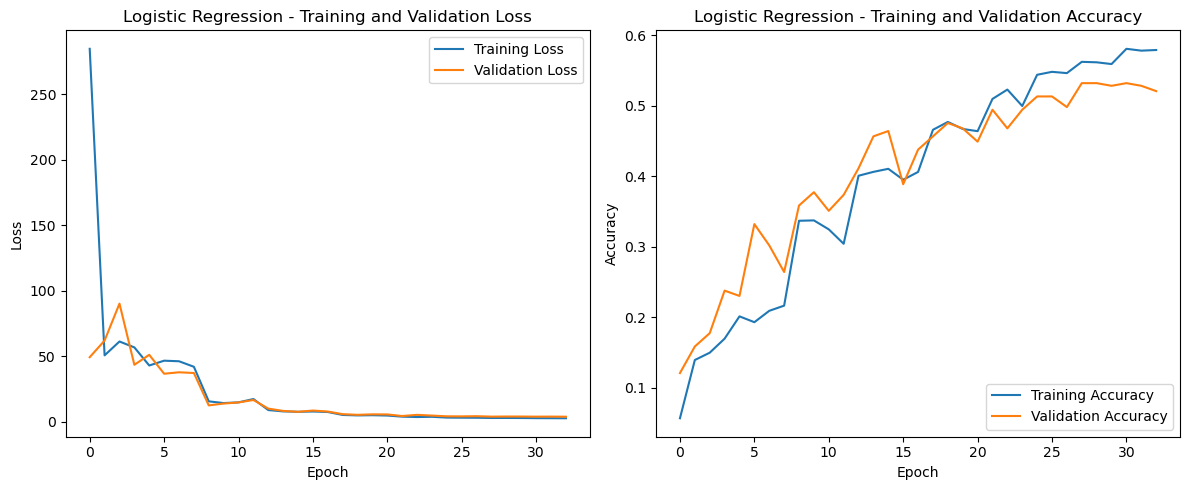

In [18]:
plot_training_history(training, 'Logistic Regression')

Loss: 5.043273448944092
Accuracy: 0.46415093541145325
Precision: 0.48812288340590215
Recall: 0.4641509433962264
F1: 0.4497631237919806
ROC AUC: 0.914245283018868

Classification Report:
                   precision    recall  f1-score   support

     ace of clubs       0.40      0.80      0.53         5
  ace of diamonds       0.75      0.60      0.67         5
    ace of hearts       0.57      0.80      0.67         5
    ace of spades       0.67      0.80      0.73         5
   eight of clubs       0.25      0.20      0.22         5
eight of diamonds       0.25      0.20      0.22         5
  eight of hearts       0.25      0.60      0.35         5
  eight of spades       0.17      0.20      0.18         5
    five of clubs       0.00      0.00      0.00         5
 five of diamonds       0.60      0.60      0.60         5
   five of hearts       0.67      0.40      0.50         5
   five of spades       0.50      0.60      0.55         5
    four of clubs       0.67      0.40      0.

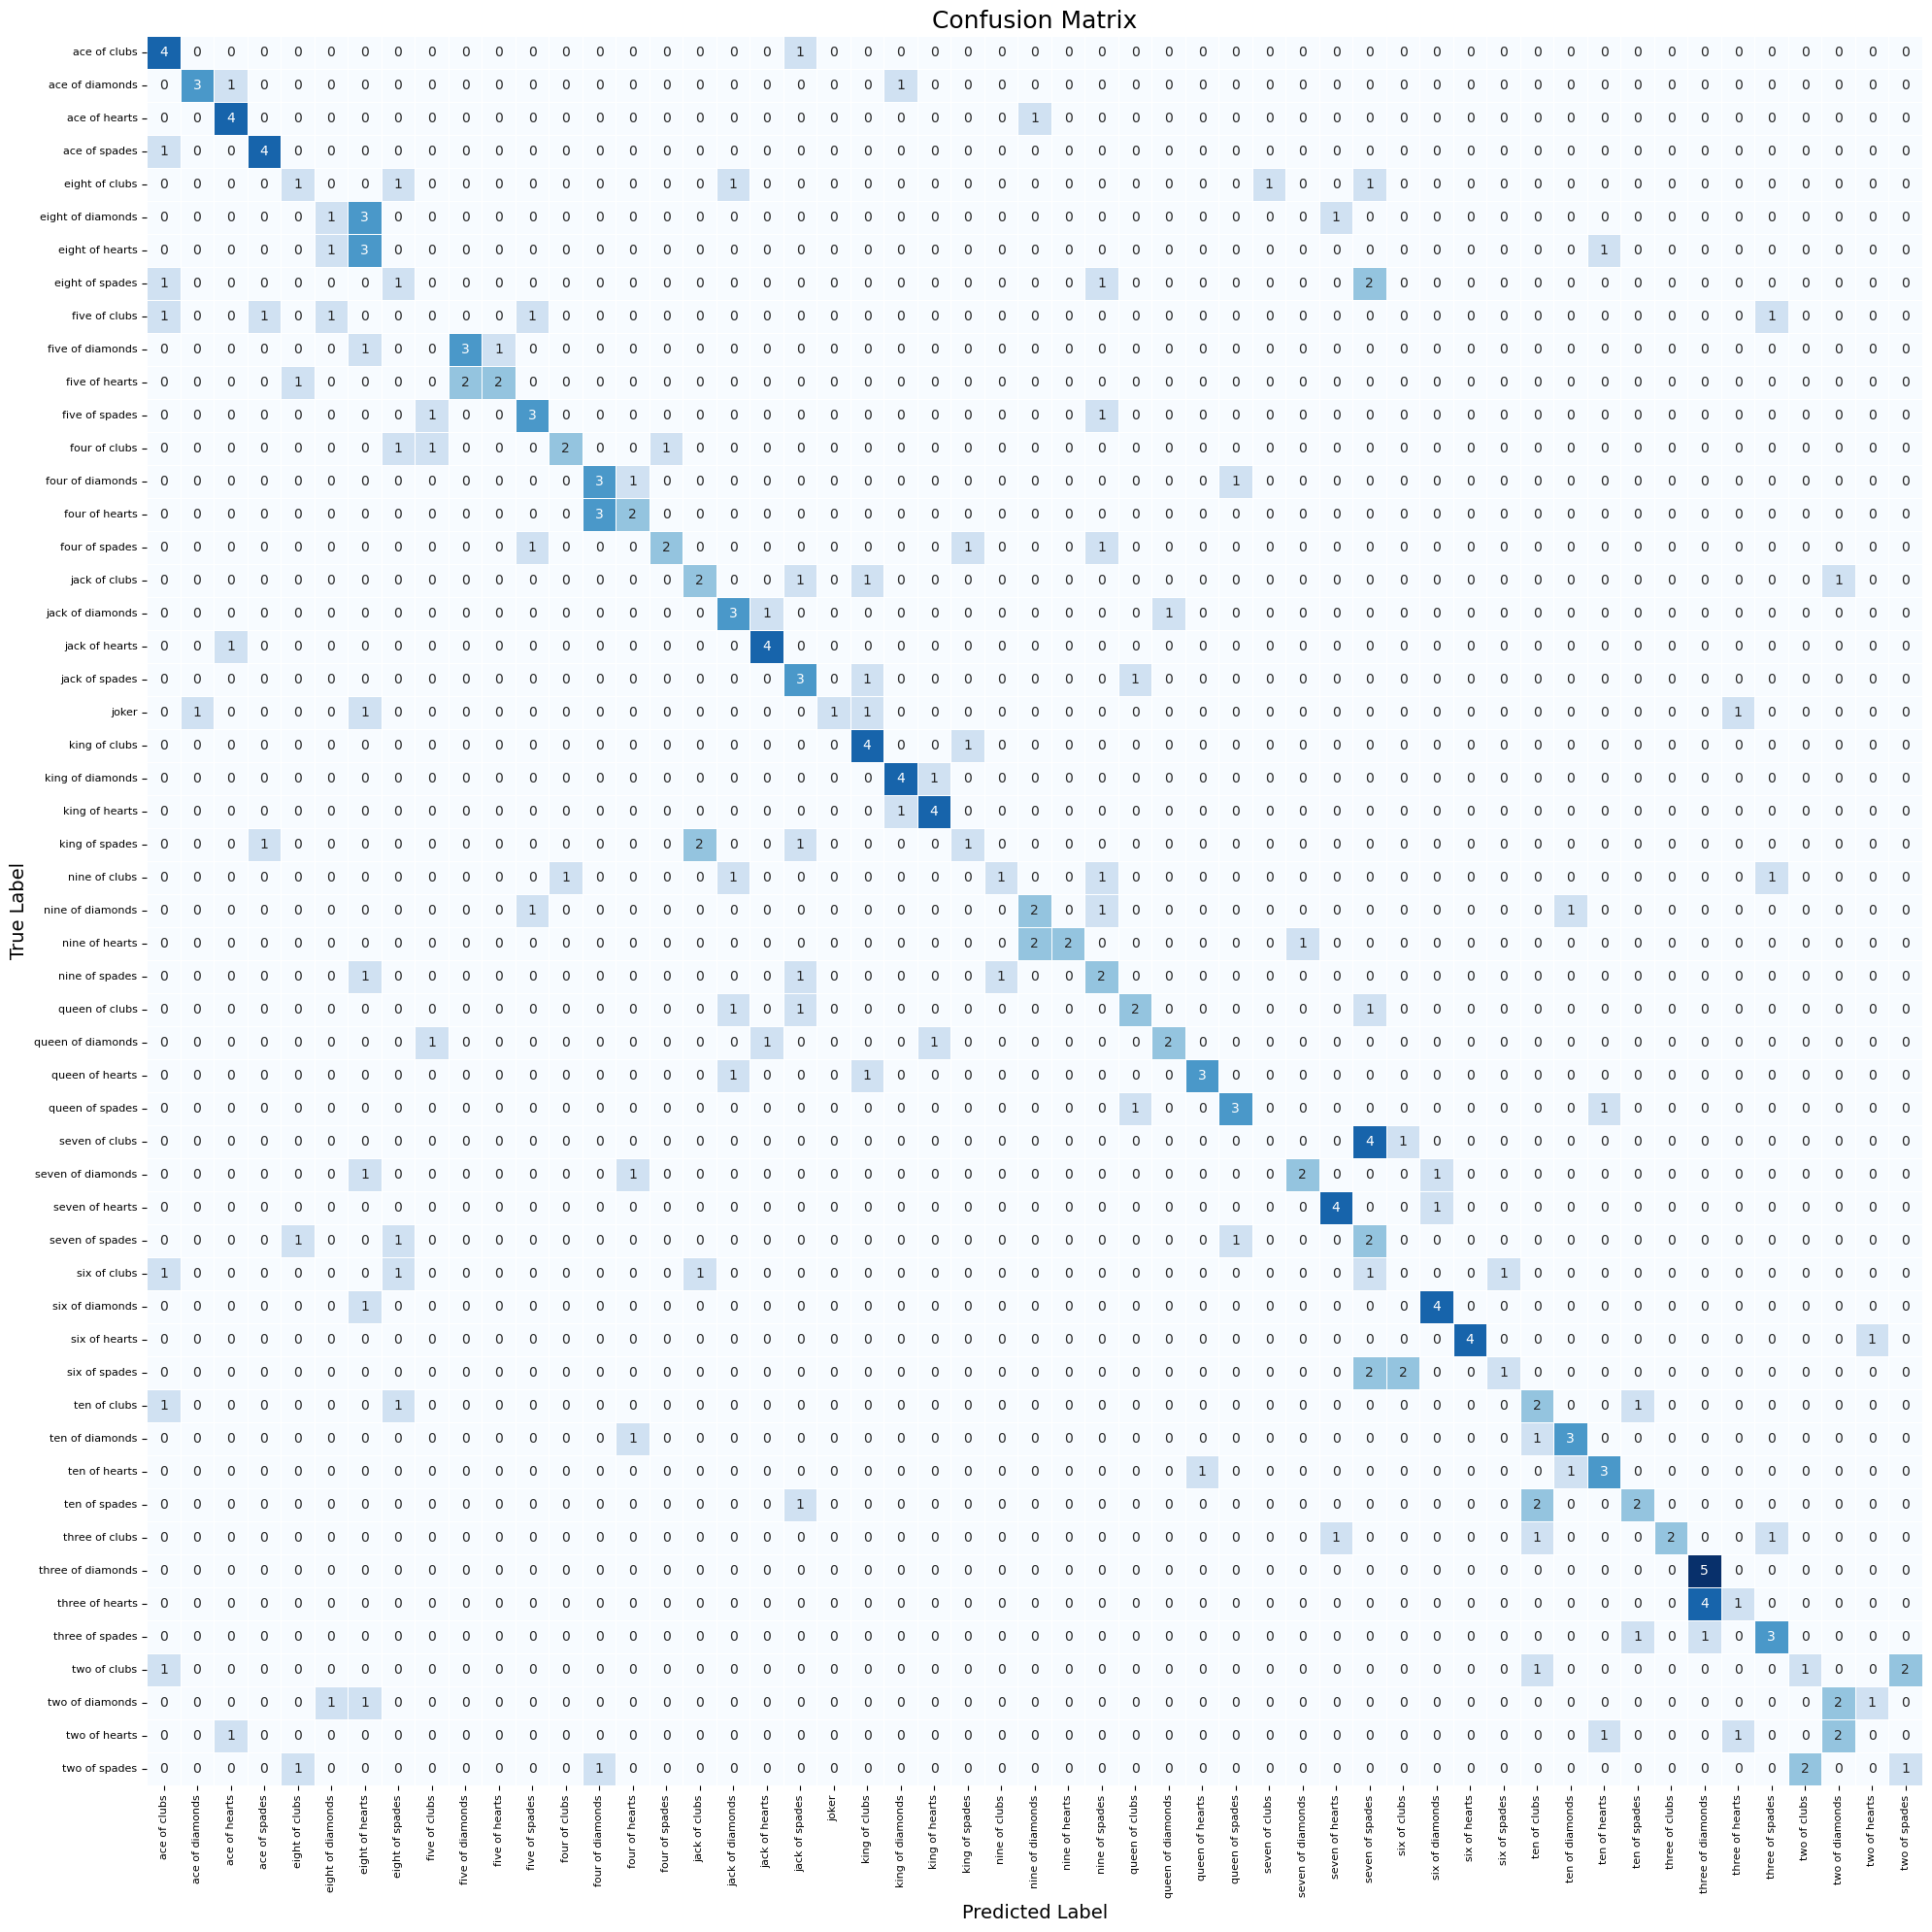

In [22]:
evaluate_model(log_reg, test_dataset)

In [ ]:
# log_reg.save('../models/logistic_regression.h5')

# Model 2: CNN

In [34]:
cnn = Sequential([
    Input(shape=IMG_SHAPE),
    Conv2D(8, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    SpatialDropout2D(0.1),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics=['accuracy'])
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 8)       608       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 16)      3216      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 56, 56, 16)       0         
 lDropout2D)                                                     
                                                      

In [35]:
training = cnn.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = callbacks,
    verbose = 1,
)

Epoch 1/100
120/120 [==============================] - 16s 22ms/step - loss: 4.0141 - accuracy: 0.0563 - val_loss: 3.1873 - val_accuracy: 0.1849 - lr: 0.0010
Epoch 2/100
120/120 [==============================] - 15s 21ms/step - loss: 3.1999 - accuracy: 0.1628 - val_loss: 2.2533 - val_accuracy: 0.3396 - lr: 0.0010
Epoch 3/100
120/120 [==============================] - 15s 21ms/step - loss: 2.7090 - accuracy: 0.2602 - val_loss: 1.8276 - val_accuracy: 0.4377 - lr: 0.0010
Epoch 4/100
120/120 [==============================] - 15s 21ms/step - loss: 2.4095 - accuracy: 0.3241 - val_loss: 1.5477 - val_accuracy: 0.5057 - lr: 0.0010
Epoch 5/100
120/120 [==============================] - 15s 22ms/step - loss: 2.2318 - accuracy: 0.3679 - val_loss: 1.4564 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 6/100
120/120 [==============================] - 15s 21ms/step - loss: 2.1000 - accuracy: 0.4136 - val_loss: 1.3339 - val_accuracy: 0.6189 - lr: 0.0010
Epoch 7/100
120/120 [==============================]

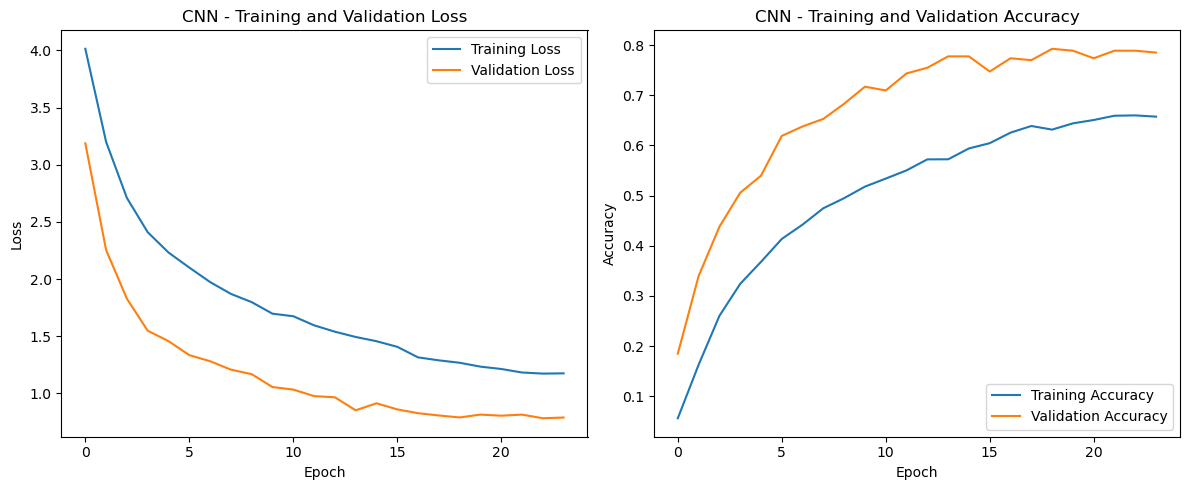

In [36]:
plot_training_history(training, 'CNN')

Loss: 0.9181126356124878
Accuracy: 0.7773584723472595
Precision: 0.8069257262653489
Recall: 0.7773584905660377
F1: 0.7722787694485805
ROC AUC: 0.9885486211901306

Classification Report:
                   precision    recall  f1-score   support

     ace of clubs       0.44      0.80      0.57         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.83      1.00      0.91         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       0.83      1.00      0.91         5
  eight of hearts       0.80      0.80      0.80         5
  eight of spades       0.80      0.80      0.80         5
    five of clubs       1.00      0.60      0.75         5
 five of diamonds       1.00      0.60      0.75         5
   five of hearts       0.80      0.80      0.80         5
   five of spades       1.00      0.80      0.89         5
    four of clubs       0.60      0.60      0.

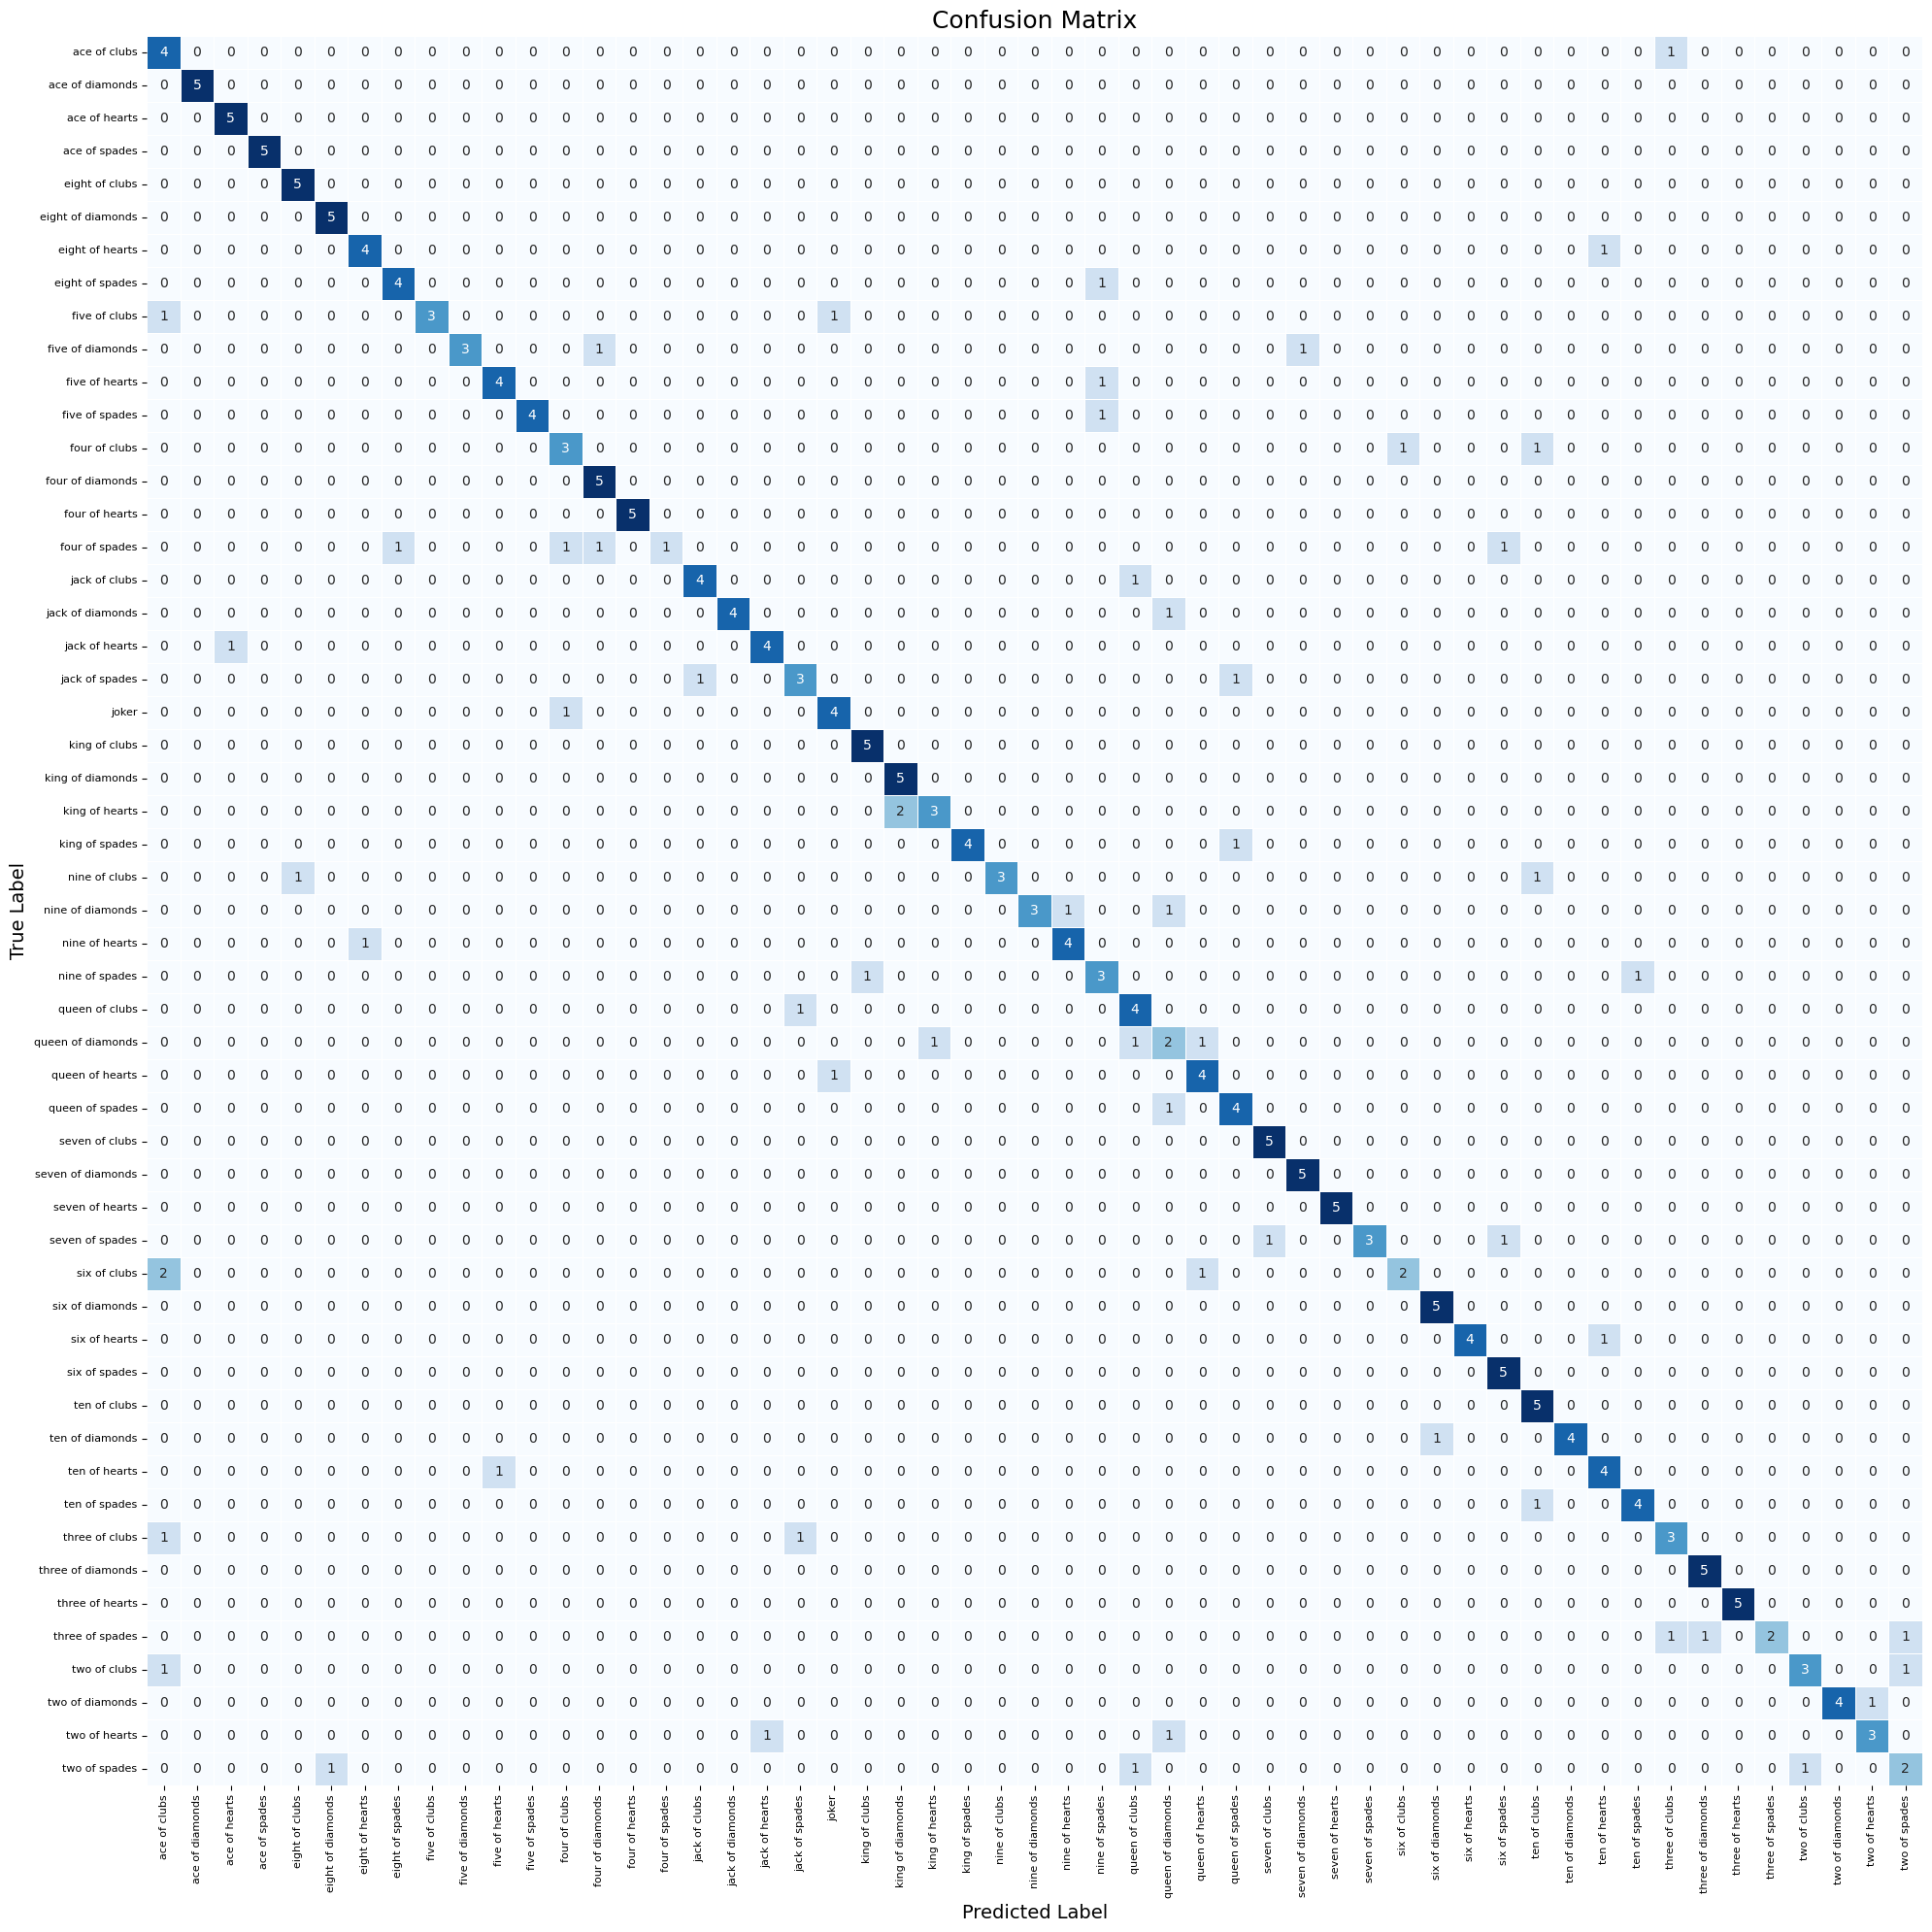

In [40]:
evaluate_model(cnn, test_dataset)

In [ ]:
# cnn.save('../models/cnn.h5')

# Model 3: MobileNetV2

In [28]:
def mobileNetV2_preprocess(image, label):
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def mobileNetV2_preprocess_augment(image, label):
    image, label = mobileNetV2_preprocess(image, label)
    image = img_augmentation(image)
    return image, label

In [29]:
base_model = MobileNetV2(
    input_shape=IMG_SHAPE, 
    weights='imagenet', 
    include_top=False
)

inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x) 
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax', )(x)

transfer_model = keras.Model(inputs, outputs)

for layer in base_model.layers:
    layer.trainable = False

transfer_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              1311744   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0     

In [30]:
# Reading images from folders
train_dataset = keras.utils.image_dataset_from_directory(TRAIN_DIR, image_size=(224, 224), batch_size=64)
test_dataset = keras.utils.image_dataset_from_directory(TEST_DIR, image_size=(224, 224), shuffle='false', batch_size=64)
val_dataset = keras.utils.image_dataset_from_directory(VAL_DIR, image_size=(224, 224), shuffle='flase', batch_size=64)

train_dataset = train_dataset.map(mobileNetV2_preprocess_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(mobileNetV2_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(mobileNetV2_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [31]:
training = transfer_model.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)],
    verbose = 1,
)

Epoch 1/100
120/120 [==============================] - 9s 38ms/step - loss: 3.3186 - accuracy: 0.1187 - val_loss: 2.1733 - val_accuracy: 0.3132
Epoch 2/100
120/120 [==============================] - 6s 33ms/step - loss: 2.4862 - accuracy: 0.2597 - val_loss: 1.8073 - val_accuracy: 0.3811
Epoch 3/100
120/120 [==============================] - 6s 33ms/step - loss: 2.1644 - accuracy: 0.3332 - val_loss: 1.6415 - val_accuracy: 0.4415
Epoch 4/100
120/120 [==============================] - 6s 33ms/step - loss: 1.9717 - accuracy: 0.4006 - val_loss: 1.5195 - val_accuracy: 0.4755
Epoch 5/100
120/120 [==============================] - 6s 32ms/step - loss: 1.8212 - accuracy: 0.4441 - val_loss: 1.3565 - val_accuracy: 0.5434
Epoch 6/100
120/120 [==============================] - 6s 32ms/step - loss: 1.6873 - accuracy: 0.4778 - val_loss: 1.3597 - val_accuracy: 0.5057
Epoch 7/100
120/120 [==============================] - 6s 32ms/step - loss: 1.5961 - accuracy: 0.5004 - val_loss: 1.3028 - val_accuracy:

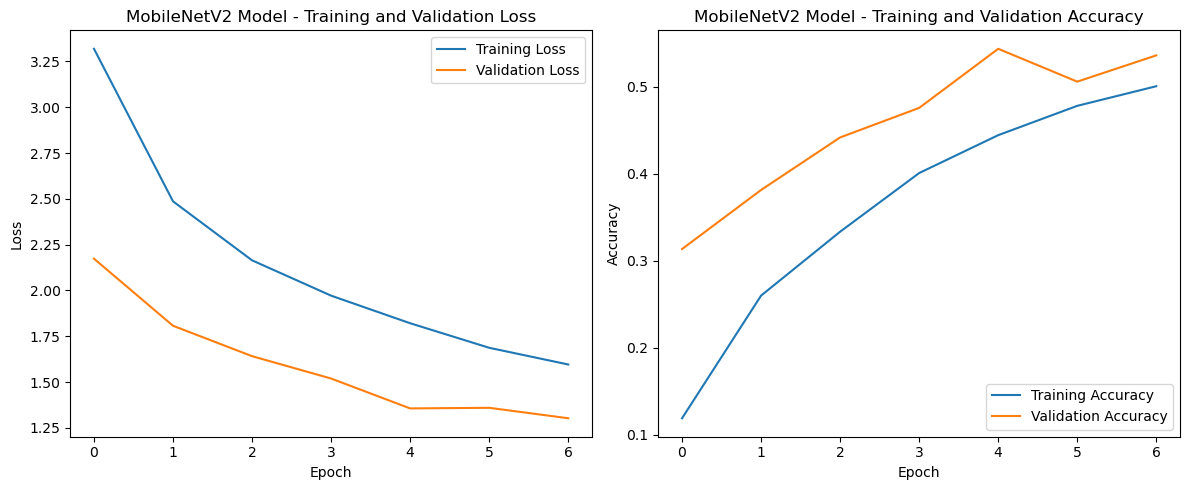

In [33]:
plot_training_history(training, 'MobileNetV2 Model')

In [34]:
loss, accuracy = transfer_model.evaluate(test_dataset)
print(f'CNN Losss {loss}')
print(f'CNN accuracy {accuracy}')

5/5 [==============================] - 0s 25ms/step - loss: 1.3927 - accuracy: 0.5698
CNN Losss 1.3927109241485596
CNN accuracy 0.5698113441467285


In [35]:
for layer in transfer_model.layers[-30:]:
      if not isinstance(layer, BatchNormalization):
         layer.trainable = True
         
transfer_model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

training = transfer_model.fit(
    train_dataset, 
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = callbacks,
    verbose = 1,
)

Epoch 1/100
120/120 [==============================] - 21s 125ms/step - loss: 2.8039 - accuracy: 0.2246 - val_loss: 1.4531 - val_accuracy: 0.4943 - lr: 1.0000e-05
Epoch 2/100
120/120 [==============================] - 17s 120ms/step - loss: 2.2925 - accuracy: 0.3207 - val_loss: 1.4234 - val_accuracy: 0.5019 - lr: 1.0000e-05
Epoch 3/100
120/120 [==============================] - 17s 120ms/step - loss: 2.0349 - accuracy: 0.3852 - val_loss: 1.2948 - val_accuracy: 0.5321 - lr: 1.0000e-05
Epoch 4/100
120/120 [==============================] - 17s 121ms/step - loss: 1.8381 - accuracy: 0.4373 - val_loss: 1.1967 - val_accuracy: 0.5623 - lr: 1.0000e-05
Epoch 5/100
120/120 [==============================] - 17s 122ms/step - loss: 1.7268 - accuracy: 0.4662 - val_loss: 1.1472 - val_accuracy: 0.5849 - lr: 1.0000e-05
Epoch 6/100
120/120 [==============================] - 17s 121ms/step - loss: 1.6095 - accuracy: 0.4983 - val_loss: 1.0986 - val_accuracy: 0.6151 - lr: 1.0000e-05
Epoch 7/100
120/120 [=

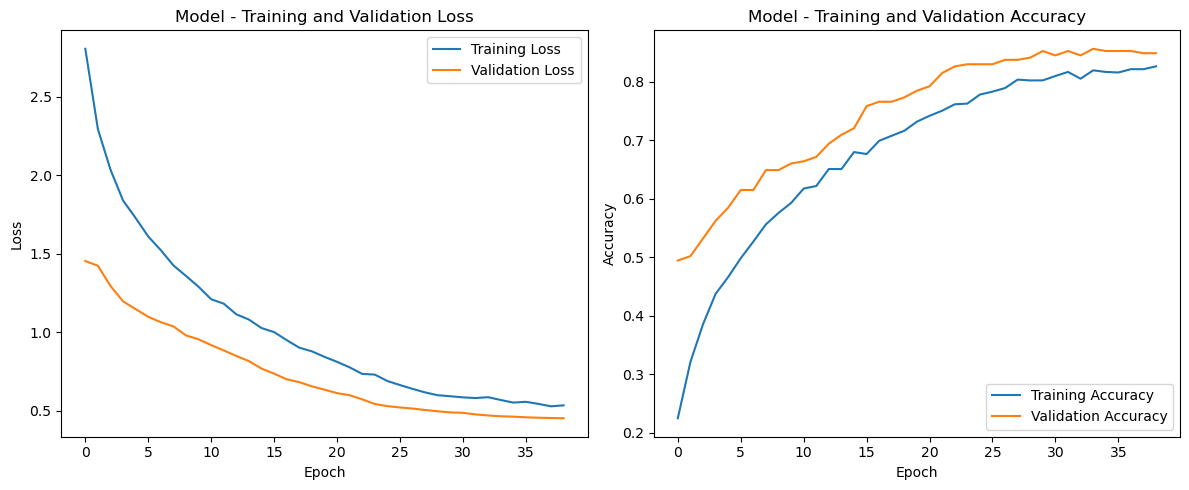

In [37]:
plot_training_history(training)

Loss: 0.782371461391449
Accuracy: 0.7698113322257996


c:\Users\james\anaconda3\envs\gpu-machine-learning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\envs\gpu-machine-learning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\james\anaconda3\envs\gpu-machine-learning\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

Precision: 0.7888215034441449
Recall: 0.7698113207547169
F1: 0.7554065431423921
ROC AUC: 0.9923947750362845

Classification Report:
                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       0.83      1.00      0.91         5
   eight of clubs       0.33      0.20      0.25         5
eight of diamonds       0.67      0.80      0.73         5
  eight of hearts       0.71      1.00      0.83         5
  eight of spades       1.00      0.80      0.89         5
    five of clubs       0.80      0.80      0.80         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       0.75      0.60      0.67         5
   five of spades       0.80      0.80      0.80         5
    four of clubs       1.00      0.60      0.75         5
 four of diamonds       1.00      1.00   

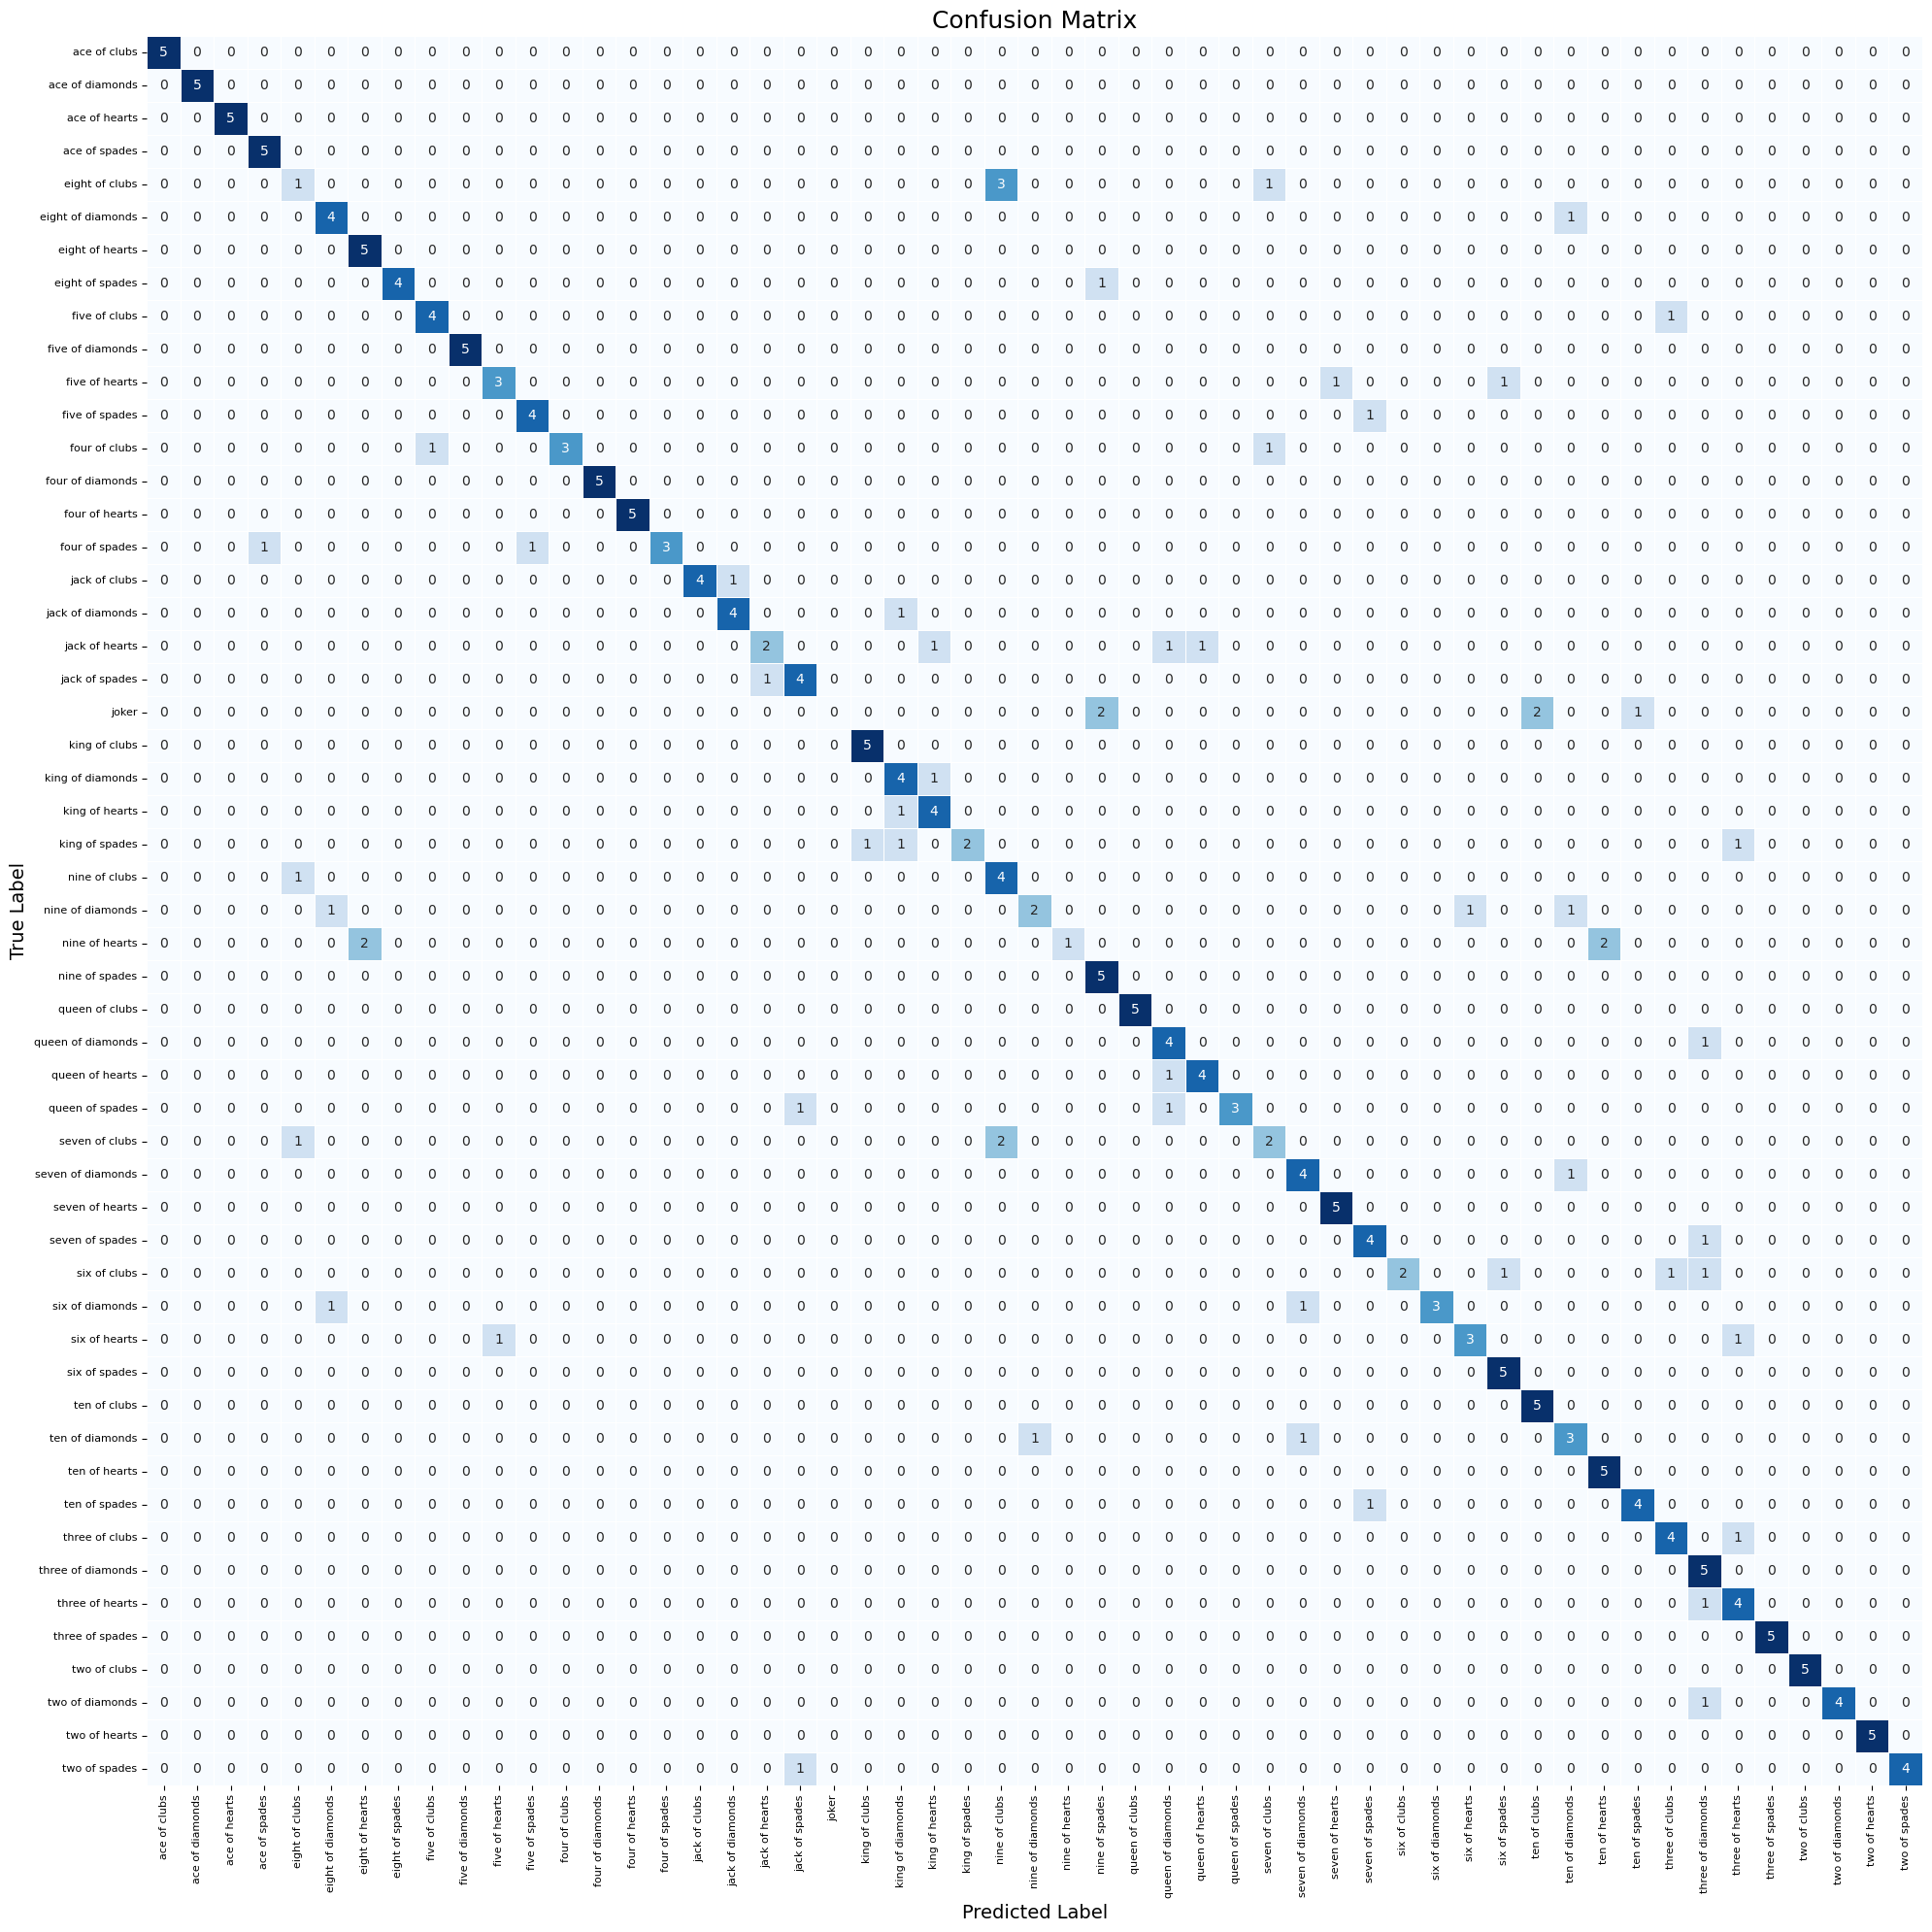

In [38]:
evaluate_model(transfer_model)

In [ ]:
# transfer_model.save('../models/mobilenetv2.h5')